In [58]:
import torch
from torch import nn
from tqdm import tqdm
from torchvision.datasets.mnist import FashionMNIST
from torchvision import transforms
import matplotlib.pyplot as plt

print("Using Device: ", torch.cuda.get_device_name())

Using Device:  Tesla T4


In [59]:
def create_datasets(data_root):
    trainset = FashionMNIST(root = data_root, train = True, download = True, transform = transforms.ToTensor())
    testset = FashionMNIST(root = data_root, train = False, download = True, transform = transforms.ToTensor())
    return trainset, testset

trainset, testset = create_datasets("./data")
batch_size = 128
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=4)

In [63]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.Tanh()
        )

    def forward(self, x):
        return self.conv_block(x)


class PoolingBlock(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super().__init__()
        self.pooling_block = nn.AvgPool2d(kernel_size=kernel_size, stride=stride)

    def forward(self, x):
        return self.pooling_block(x)

class LeNet5(torch.nn.Module):
    def __init__(self, n_channels=1, batchnorm=False, dropout=False):
        super().__init__()
        self.n_channels = n_channels
        self.batchnorm = batchnorm
        self.do_dropout = dropout

        self.conv1 = ConvBlock(in_channels=n_channels, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.pooling1 = PoolingBlock(kernel_size=2, stride=2)
        self.conv2 = ConvBlock(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.pooling2 = PoolingBlock(kernel_size=2, stride=2)
        self.conv3 = ConvBlock(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        self.activation = nn.Tanh()
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)
        # self.softmax = nn.Softmax()
        if self.do_dropout:
            self.dropout = nn.Dropout(p=0.75)
        # self.batch_norm = nn.BatchNorm1d()
        if self.batchnorm:
            self.batch_norm1 = nn.BatchNorm2d(num_features=6)
            self.batch_norm2 = nn.BatchNorm2d(num_features=16)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pooling1(x)
        if self.batchnorm:
            x = self.batch_norm1(x)
        x = self.conv2(x)
        x = self.pooling2(x)
        if self.batchnorm:
            x = self.batch_norm2(x)
        x = self.conv3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        if self.do_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [64]:
def compute_accuracy(est_labels, labels):
    correct_pred = torch.sum(est_labels == labels)
    total = labels.shape[0]
    return correct_pred / total

def train_epoch(net, dataloader, loss_func, optimizer):
    net.train()
    all_losses = []
    all_acc = []
    for batch in dataloader:
        optimizer.zero_grad()

        images, labels = batch
        images, labels = images.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)
        
        est_labels = net(images)
        loss = loss_func(est_labels, labels)
        all_losses.append(loss.item())
        
        if net.do_dropout:
            net.eval()
            all_acc.append(compute_accuracy(torch.argmax(net(images), dim=1), labels))
            net.train()
        else:
          all_acc.append(compute_accuracy(torch.argmax(est_labels, dim=1), labels))

        loss.backward()
        optimizer.step()
    return all_losses, all_acc

def eval(net, dataloader, loss_func):
    net.eval()
    all_losses = []
    all_acc = []
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images, labels = images.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)
        
            est_labels = net(images)
            all_losses.append(loss_func(est_labels, labels).item())
            all_acc.append(compute_accuracy(torch.argmax(est_labels, dim=1), labels))

    return all_losses, all_acc

def train(net, train_loader, val_loader, num_epochs, loss_func, optimizer):
    all_train_losses = []
    all_train_acc = []
    all_val_losses = []
    all_val_acc = []
    for epoch in range(num_epochs):
        print("Training Epoch %d / %d" % (epoch, num_epochs))
        train_losses, train_acc = train_epoch(net, train_loader, loss_func, optimizer)
        all_train_losses.append(train_losses)
        all_train_acc.append(train_acc)
        val_losses, val_acc = eval(net, val_loader, loss_func)
        print("Epoch %d train loss: %f, train_acc: %f, val loss: %f, val accuracy: %f" %
              (epoch, sum(train_losses) / len(train_losses), sum(train_acc) / len(train_acc),
               sum(val_losses) / len(val_losses), sum(val_acc) / len(val_acc)))
        all_val_losses.append(val_losses)
        all_val_acc.append(val_acc)
    print("Done training")
    return all_train_losses, all_train_acc, all_val_losses, all_val_acc
        


In [69]:
net = LeNet5().to(device)
# net = LeNet5(dropout=True).to(device)
# net = LeNet5(batchnorm=True).to(device)

optimizer = torch.optim.Adam(net.parameters())
# optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-2)

loss_func = torch.nn.CrossEntropyLoss()
num_epochs = 20
all_train_losses, all_train_acc, all_val_losses, all_val_acc = train(net, train_loader, test_loader, num_epochs, loss_func, optimizer)

Training Epoch 0 / 20
Epoch 0 train loss: 0.558140, train_acc: 0.815232, val loss: 0.454707, val accuracy: 0.843354
Training Epoch 1 / 20
Epoch 1 train loss: 0.419703, train_acc: 0.854000, val loss: 0.433769, val accuracy: 0.850574
Training Epoch 2 / 20
Epoch 2 train loss: 0.393909, train_acc: 0.863856, val loss: 0.414695, val accuracy: 0.854035
Training Epoch 3 / 20
Epoch 3 train loss: 0.383310, train_acc: 0.866638, val loss: 0.408521, val accuracy: 0.859078
Training Epoch 4 / 20
Epoch 4 train loss: 0.373402, train_acc: 0.871480, val loss: 0.433791, val accuracy: 0.849288
Training Epoch 5 / 20
Epoch 5 train loss: 0.370713, train_acc: 0.872957, val loss: 0.414483, val accuracy: 0.853244
Training Epoch 6 / 20
Epoch 6 train loss: 0.367226, train_acc: 0.873062, val loss: 0.397935, val accuracy: 0.860364
Training Epoch 7 / 20
Epoch 7 train loss: 0.362263, train_acc: 0.875372, val loss: 0.390027, val accuracy: 0.865210
Training Epoch 8 / 20
Epoch 8 train loss: 0.361810, train_acc: 0.875994,

Max Accuracy train: 0.881141185760498
Max Accuracy val: 0.8734177350997925


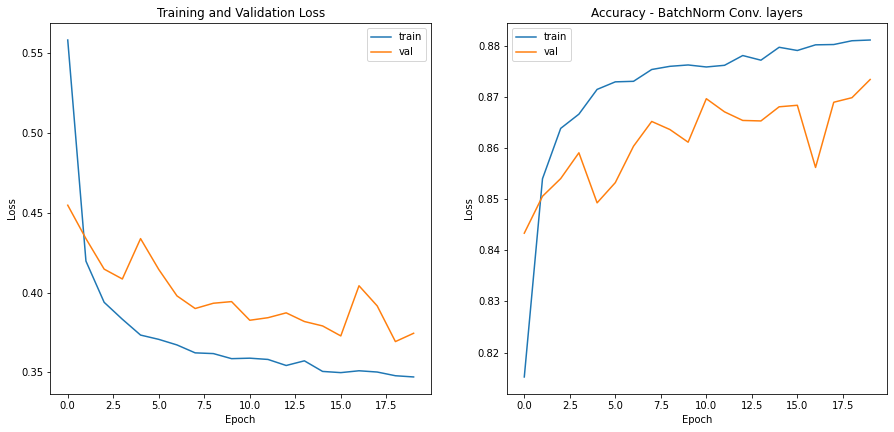

In [70]:
train_losses = [sum(x) / len(x) for x in all_train_losses]
train_acc = [sum(x) / len(x) for x in all_train_acc]
val_losses = [sum(x) / len(x) for x in all_val_losses]
val_acc = [sum(x) / len(x) for x in all_val_acc]

print("Max Accuracy train:", max(train_acc).item())
print("Max Accuracy val:", max(val_acc).item())

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['train', 'val'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

plt.subplot(2, 2, 2)
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['train', 'val'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Accuracy - BatchNorm Conv. layers")
plt.show()